# Do not update the first cell (it's related to surface/formation structure)

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Delaunay
import trimesh
from _visualize_surface import visualize_surface

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
depth:float = 100
thickness:float = 50
slip_diff:float = 10


## basic settings
epsilon = 50
x_0, x_1 = 0.0, 1000
y_0, y_1 = 0.0, 1000
num_interval = 50
bin_size = (x_1-x_0)/num_interval
## generate surfaces
x_bins = np.arange(x_0,x_1,bin_size)
y_bins = np.arange(y_0,y_1,bin_size)
mesh_x, mesh_y = np.meshgrid(x_bins, y_bins)
# top & bottom flat
mesh_z_top = -depth * np.ones_like(mesh_x)
mesh_z_bottom = -(depth + thickness ) * np.ones_like(mesh_x)
# add slip when x_bins is larger than 50
mesh_z_top[mesh_x>x_1/2] -= slip_diff
mesh_z_bottom[mesh_x>x_1/2] -= slip_diff

## Triangulation
pts = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1)],axis = 1)
pts_3d = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1), mesh_z_top.reshape(-1,1)],axis = 1)
pts_3d_2 = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1), mesh_z_bottom.reshape(-1,1)],axis = 1)

tri = Delaunay(pts)
top = trimesh.Trimesh(vertices=pts_3d,
                    faces=tri.simplices,
                    process=True)
bottom = trimesh.Trimesh(vertices=pts_3d_2,
                    faces=tri.simplices,
                    process=True)

## generate surfaces
x_bins = np.ones(num_interval)*510
y_bins = np.arange(y_0,y_1,bin_size)
mesh_x, mesh_y = np.meshgrid(x_bins, y_bins)
# top & bottom flat
mesh_z_top =  np.repeat(np.linspace(-200, 0, int(num_interval), endpoint=True ).reshape(-1,1), repeats=int(num_interval), axis = 1 ).T
pts = np.concatenate([mesh_z_top.reshape(-1,1),mesh_y.reshape(-1,1)],axis = 1)
pts_3d = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1), mesh_z_top.reshape(-1,1)],axis = 1)
tri = Delaunay(pts)
fault = trimesh.Trimesh(vertices=pts_3d,
                     faces=tri.simplices,
                     process=True)

In [3]:
# visualize_surface([top,bottom,fault])

In [4]:
from trimesh.proximity import signed_distance


In [5]:
distances = signed_distance(fault, top.vertices)
flag = top.faces.reshape(-1,3)
arr = np.sign(distances[flag])
rows_identical = np.all(arr == arr[:, [0]], axis=1)
group_positive = np.all(arr == 1, axis=1)
group_negative = np.all(arr == -1, axis=1)

In [6]:
depth:float = 100
thickness:float = 50
slip_diff:float = 10

## basic settings
epsilon = 50
x_0, x_1 = 0.0, 1000
y_0, y_1 = 0.0, 1000
num_interval = 50
bin_size = (x_1-x_0)/num_interval
## generate surfaces
x_bins = np.arange(x_0,x_1,bin_size)
y_bins = np.arange(y_0,y_1,bin_size)
mesh_x, mesh_y = np.meshgrid(x_bins, y_bins)
# top & bottom flat
mesh_z_top = -depth * np.ones_like(mesh_x)
mesh_z_bottom = -(depth + thickness ) * np.ones_like(mesh_x)
# add slip when x_bins is larger than 50
mesh_z_top[mesh_x>x_1/2] -= slip_diff
mesh_z_bottom[mesh_x>x_1/2] -= slip_diff

## Triangulation
pts = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1)],axis = 1)
pts_3d = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1), mesh_z_top.reshape(-1,1)],axis = 1)
pts_3d_2 = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1), mesh_z_bottom.reshape(-1,1)],axis = 1)

tri = Delaunay(pts)
top = trimesh.Trimesh(vertices=pts_3d,
                    faces=tri.simplices[rows_identical],
                    process=True)
bottom = trimesh.Trimesh(vertices=pts_3d_2,
                    faces=tri.simplices[rows_identical],
                    process=True)

In [7]:
# visualize_surface([top,bottom,fault])

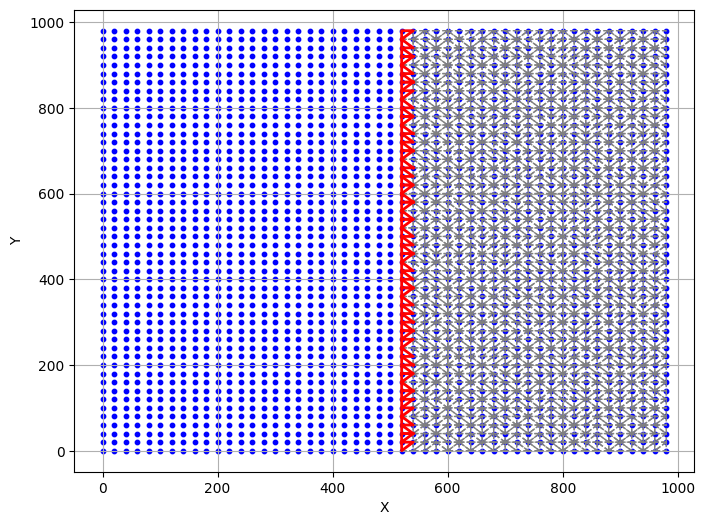

In [8]:
# top에서 3개의 꼭짓점의 sin값이 +1에 해당하는 면 생성
tri_top_positive=tri.simplices[group_positive]
# +1에 해당하는 면들의 모서리 중복 개수 세기
edges_top_positive = np.vstack([
    tri_top_positive[:, [0, 1]],
    tri_top_positive[:, [1, 2]],
    tri_top_positive[:, [2, 0]]
])

edges_top_positive = np.sort(edges_top_positive, axis=1)
edges_top_positive, counts = np.unique(edges_top_positive, axis=0, return_counts=True)
# 개수가 1개인 모서리를 외곽 모서리로 지정
boundary_edges_top_positive = edges_top_positive[counts == 1]

# 상부 전체의 외곽 모서리
tri_top = tri.simplices
edges_top = np.vstack([
    tri_top[:, [0, 1]],
    tri_top[:, [1, 2]],
    tri_top[:, [2, 0]]
])
edges_top = np.sort(edges_top, axis=1)
edges_top, counts = np.unique(edges_top, axis=0, return_counts=True)
boundary_edges_top = edges_top[counts == 1]

# +1면의 외곽 모서리, 전체 면 외곽 모서리 차집합
close_to_fault_edges_top_positive = np.array(list(set(map(tuple, boundary_edges_top_positive)) - set(map(tuple, boundary_edges_top))))

# 외곽 모서리가 속해있는 xy좌표에서 삼각형 찾기
fault_edge_set = set(map(tuple, close_to_fault_edges_top_positive))

close_to_fault_triangle_top_positive = []

for triangle in tri_top_positive:
    # 각 모서리를 튜플 형태로 추출 (인덱스 순서를 오름차순 정렬)
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    # 세 모서리 중 하나라도 fault_edge_set에 있다면 해당 삼각형은 외곽에 해당하는 것으로 판단
    if edge1 in fault_edge_set or edge2 in fault_edge_set or edge3 in fault_edge_set:
        close_to_fault_triangle_top_positive.append(triangle)



#시각화
points_xy = pts
fig, ax = plt.subplots(figsize=(8, 6))

for triangle in tri_top_positive:
    vertices = points_xy[triangle]
    vertices = np.vstack([vertices, vertices[0]])
    ax.plot(vertices[:, 0], vertices[:, 1], color='gray', linestyle='--', linewidth=1)

for triangle in close_to_fault_triangle_top_positive:
    vertices = points_xy[triangle]
    vertices = np.vstack([vertices, vertices[0]])
    ax.plot(vertices[:, 0], vertices[:, 1], color='red', linestyle='-', linewidth=2)

ax.scatter(points_xy[:, 0], points_xy[:, 1], color='blue', s=10)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.show()

In [9]:
# 3D에서 fault와의 교점 구하기
intersection_point = []

for triangle in close_to_fault_triangle_top_positive:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins = np.atleast_2d(C_coord),
            ray_directions = np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)
intersection_point

[array([[ 510.,  800., -110.]]),
 array([[ 510.,  830., -110.]]),
 array([[ 510.,  810., -110.]]),
 array([[ 510.,  840., -110.]]),
 array([[ 510.,  920., -110.]]),
 array([[ 510.,  950., -110.]]),
 array([[ 510.,  510., -110.]]),
 array([[ 510.,  540., -110.]]),
 array([[ 510.,  500., -110.]]),
 array([[ 510.,  530., -110.]]),
 array([[ 510.,  480., -110.]]),
 array([[ 510.,  510., -110.]]),
 array([[ 510.,  740., -110.]]),
 array([[ 510.,  770., -110.]]),
 array([[ 510.,  860., -110.]]),
 array([[ 510.,  890., -110.]]),
 array([[ 510.,  830., -110.]]),
 array([[ 510.,  860., -110.]]),
 array([[ 510.,   40., -110.]]),
 array([[ 510.,   70., -110.]]),
 array([[ 510.,  940., -110.]]),
 array([[ 510.,  970., -110.]]),
 array([[ 510.,  950., -110.]]),
 array([[ 510.,  980., -110.]]),
 array([[ 510.,  660., -110.]]),
 array([[ 510.,  690., -110.]]),
 array([[ 510.,  540., -110.]]),
 array([[ 510.,  570., -110.]]),
 array([[ 510.,  780., -110.]]),
 array([[ 510.,  810., -110.]]),
 array([[ 

In [12]:
#fault와 가까운 점들 구하기
close_to_fault_points_top_positive = []
for triangle in close_to_fault_triangle_top_positive:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]
        close_to_fault_points_top_positive.append([A_coord])
        close_to_fault_points_top_positive.append([B_coord])

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]
        close_to_fault_points_top_positive.append([A_coord])
        close_to_fault_points_top_positive.append([B_coord])

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]
        close_to_fault_points_top_positive.append([A_coord])
        close_to_fault_points_top_positive.append([B_coord])
close_to_fault_points_top_positive

[[array([ 520.,  800., -110.])],
 [array([ 520.,  820., -110.])],
 [array([ 520.,  820., -110.])],
 [array([ 520.,  840., -110.])],
 [array([ 520.,  920., -110.])],
 [array([ 520.,  940., -110.])],
 [array([ 520.,  520., -110.])],
 [array([ 520.,  540., -110.])],
 [array([ 520.,  500., -110.])],
 [array([ 520.,  520., -110.])],
 [array([ 520.,  480., -110.])],
 [array([ 520.,  500., -110.])],
 [array([ 520.,  740., -110.])],
 [array([ 520.,  760., -110.])],
 [array([ 520.,  860., -110.])],
 [array([ 520.,  880., -110.])],
 [array([ 520.,  840., -110.])],
 [array([ 520.,  860., -110.])],
 [array([ 520.,   40., -110.])],
 [array([ 520.,   60., -110.])],
 [array([ 520.,  940., -110.])],
 [array([ 520.,  960., -110.])],
 [array([ 520.,  960., -110.])],
 [array([ 520.,  980., -110.])],
 [array([ 520.,  660., -110.])],
 [array([ 520.,  680., -110.])],
 [array([ 520.,  540., -110.])],
 [array([ 520.,  560., -110.])],
 [array([ 520.,  780., -110.])],
 [array([ 520.,  800., -110.])],
 [array([ 

In [13]:
close_to_fault_points_top_positive_3d = np.vstack(close_to_fault_points_top_positive)
close_to_fault_points_top_positive_3d = np.unique(close_to_fault_points_top_positive_3d, axis=0)
close_to_fault_points_top_positive_xy = close_to_fault_points_top_positive_3d[:, :2]

fault_intersections_top_positive = [pt for pt in intersection_point if pt.size != 0]
intersection_top_positive_point_3d = np.vstack(fault_intersections_top_positive)
intersection_top_positive_point_xy = intersection_top_positive_point_3d[:, :2]

combined_top_positive_points_xy = np.vstack((intersection_top_positive_point_xy, close_to_fault_points_top_positive_xy))
combined_top_positive_points_3d = np.vstack((intersection_top_positive_point_3d, close_to_fault_points_top_positive_3d))

close_to_fault_positive_top = trimesh.Trimesh(vertices=combined_top_positive_points_3d,
                    faces=Delaunay(combined_top_positive_points_xy).simplices,
                    process=True)

In [14]:
visualize_surface([top,bottom,fault,close_to_fault_positive_top])

In [13]:
depth:float = 100
thickness:float = 50
slip_diff:float = 10

## basic settings
epsilon = 50
x_0, x_1 = 0.0, 1000
y_0, y_1 = 0.0, 1000
num_interval = 50
bin_size = (x_1-x_0)/num_interval
## generate surfaces
x_bins = np.arange(x_0,x_1,bin_size)
y_bins = np.arange(y_0,y_1,bin_size)
mesh_x, mesh_y = np.meshgrid(x_bins, y_bins)
# top & bottom flat
mesh_z_top = -depth * np.ones_like(mesh_x)
mesh_z_bottom = -(depth + thickness ) * np.ones_like(mesh_x)
# add slip when x_bins is larger than 50
mesh_z_top[mesh_x>x_1/2] -= slip_diff
mesh_z_bottom[mesh_x>x_1/2] -= slip_diff

## Triangulation
pts = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1)],axis = 1)
pts_3d = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1), mesh_z_top.reshape(-1,1)],axis = 1)
pts_3d_2 = np.concatenate([mesh_x.reshape(-1,1), mesh_y.reshape(-1,1), mesh_z_bottom.reshape(-1,1)],axis = 1)

tri = Delaunay(pts)
top = trimesh.Trimesh(vertices=pts_3d,
                    faces=tri.simplices[rows_identical],
                    process=True)
bottom = trimesh.Trimesh(vertices=pts_3d_2,
                    faces=tri.simplices[rows_identical],
                    process=True)
##############################################################################################################################################

# top에서 3개의 꼭짓점의 sin값이 +1에 해당하는 면 생성
tri_top_positive=tri.simplices[group_positive]
# +1에 해당하는 면들의 모서리 중복 개수 세기
edges_top_positive = np.vstack([
    tri_top_positive[:, [0, 1]],
    tri_top_positive[:, [1, 2]],
    tri_top_positive[:, [2, 0]]
])

edges_top_positive = np.sort(edges_top_positive, axis=1)
edges_top_positive, counts = np.unique(edges_top_positive, axis=0, return_counts=True)
# 개수가 1개인 모서리를 외곽 모서리로 지정
boundary_edges_top_positive = edges_top_positive[counts == 1]

# 상부 전체의 외곽 모서리
tri_top = tri.simplices
edges_top = np.vstack([
    tri_top[:, [0, 1]],
    tri_top[:, [1, 2]],
    tri_top[:, [2, 0]]
])
edges_top = np.sort(edges_top, axis=1)
edges_top, counts = np.unique(edges_top, axis=0, return_counts=True)
boundary_edges_top = edges_top[counts == 1]

# +1면의 외곽 모서리, 전체 면 외곽 모서리 차집합
close_to_fault_edges_top_positive = np.array(list(set(map(tuple, boundary_edges_top_positive)) - set(map(tuple, boundary_edges_top))))

# 외곽 모서리가 속해있는 xy좌표에서 삼각형 찾기
fault_edge_set = set(map(tuple, close_to_fault_edges_top_positive))

close_to_fault_triangle_top_positive = []

for triangle in tri_top_positive:
    # 각 모서리를 튜플 형태로 추출 (인덱스 순서를 오름차순 정렬)
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    # 세 모서리 중 하나라도 fault_edge_set에 있다면 해당 삼각형은 외곽에 해당하는 것으로 판단
    if edge1 in fault_edge_set or edge2 in fault_edge_set or edge3 in fault_edge_set:
        close_to_fault_triangle_top_positive.append(triangle)

# 3D에서 fault와의 교점 구하기
intersection_point = []
for triangle in close_to_fault_triangle_top_positive:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins = np.atleast_2d(C_coord),
            ray_directions = np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

close_to_fault_points_top_positive = []
for triangle in close_to_fault_triangle_top_positive:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]
        close_to_fault_points_top_positive.append([A_coord])
        close_to_fault_points_top_positive.append([B_coord])

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]
        close_to_fault_points_top_positive.append([A_coord])
        close_to_fault_points_top_positive.append([B_coord])

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]
        close_to_fault_points_top_positive.append([A_coord])
        close_to_fault_points_top_positive.append([B_coord])

close_to_fault_points_top_positive_3d = np.vstack(close_to_fault_points_top_positive)
close_to_fault_points_top_positive_3d = np.unique(close_to_fault_points_top_positive_3d, axis=0)
close_to_fault_points_top_positive_xy = close_to_fault_points_top_positive_3d[:, :2]

faultintersections_top_positive = [pt for pt in intersection_point if pt.size != 0]
intersection_top_positive_point_3d = np.vstack(fault_intersections_top_positive)
intersection_top_positive_point_xy = intersection_top_positive_point_3d[:, :2]

combined_top_positive_points_xy = np.vstack((intersection_top_positive_point_xy, close_to_fault_points_top_positive_xy))
combined_top_positive_points_3d = np.vstack((intersection_top_positive_point_3d, close_to_fault_points_top_positive_3d))

close_to_fault_positive_top = trimesh.Trimesh(vertices=combined_top_positive_points_3d,
                    faces=Delaunay(combined_top_positive_points_xy).simplices,
                    process=True)

In [14]:

# top에서 3개의 꼭짓점의 sin값이 +1에 해당하는 면 생성
tri_top_negative=tri.simplices[group_negative]
# +1에 해당하는 면들의 모서리 중복 개수 세기
edges_top_negative = np.vstack([
    tri_top_negative[:, [0, 1]],
    tri_top_negative[:, [1, 2]],
    tri_top_negative[:, [2, 0]]
])

edges_top_negative = np.sort(edges_top_negative, axis=1)
edges_top_negative, counts = np.unique(edges_top_negative, axis=0, return_counts=True)
# 개수가 1개인 모서리를 외곽 모서리로 지정
boundary_edges_top_negative = edges_top_negative[counts == 1]

# 상부 전체의 외곽 모서리
tri_top = tri.simplices
edges_top = np.vstack([
    tri_top[:, [0, 1]],
    tri_top[:, [1, 2]],
    tri_top[:, [2, 0]]
])
edges_top = np.sort(edges_top, axis=1)
edges_top, counts = np.unique(edges_top, axis=0, return_counts=True)
boundary_edges_top = edges_top[counts == 1]

# +1면의 외곽 모서리, 전체 면 외곽 모서리 차집합
close_to_fault_edges_top_negative = np.array(list(set(map(tuple, boundary_edges_top_negative)) - set(map(tuple, boundary_edges_top))))

# 외곽 모서리가 속해있는 xy좌표에서 삼각형 찾기
fault_edge_set = set(map(tuple, close_to_fault_edges_top_negative))

close_to_fault_triangle_top_negative = []

for triangle in tri_top_negative:
    # 각 모서리를 튜플 형태로 추출 (인덱스 순서를 오름차순 정렬)
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    # 세 모서리 중 하나라도 fault_edge_set에 있다면 해당 삼각형은 외곽에 해당하는 것으로 판단
    if edge1 in fault_edge_set or edge2 in fault_edge_set or edge3 in fault_edge_set:
        close_to_fault_triangle_top_negative.append(triangle)

# 3D에서 fault와의 교점 구하기
intersection_point = []

for triangle in close_to_fault_triangle_top_negative:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins = np.atleast_2d(C_coord),
            ray_directions = np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

close_to_fault_points_top_negative = []

for triangle in close_to_fault_triangle_top_negative:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]
        close_to_fault_points_top_negative.append([A_coord])
        close_to_fault_points_top_negative.append([B_coord])

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]
        close_to_fault_points_top_negative.append([A_coord])
        close_to_fault_points_top_negative.append([B_coord])

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d[A]
        B_coord = pts_3d[B]
        C_coord = pts_3d[C]
        close_to_fault_points_top_negative.append([A_coord])
        close_to_fault_points_top_negative.append([B_coord])

close_to_fault_points_top_negative_3d = np.vstack(close_to_fault_points_top_negative)
close_to_fault_points_top_negative_3d = np.unique(close_to_fault_points_top_negative_3d, axis=0)
close_to_fault_points_top_negative_xy = close_to_fault_points_top_negative_3d[:, :2]

fault_intersections_top_negative = [pt for pt in intersection_point if pt.size != 0]
intersection_top_negative_point_3d = np.vstack(fault_intersections_top_negative)
intersection_top_negative_point_xy = intersection_top_negative_point_3d[:, :2]

combined_top_negative_points_xy = np.vstack((intersection_top_negative_point_xy, close_to_fault_points_top_negative_xy))
combined_top_negative_points_3d = np.vstack((intersection_top_negative_point_3d, close_to_fault_points_top_negative_3d))

close_to_fault_negative_top = trimesh.Trimesh(vertices=combined_top_negative_points_3d,
                    faces=Delaunay(combined_top_negative_points_xy).simplices,
                    process=True)

In [15]:
# bottom에서 3개의 꼭짓점의 sin값이 +1에 해당하는 면 생성
tri_bottom_positive=tri.simplices[group_positive]
# +1에 해당하는 면들의 모서리 중복 개수 세기
edges_bottom_positive = np.vstack([
    tri_bottom_positive[:, [0, 1]],
    tri_bottom_positive[:, [1, 2]],
    tri_bottom_positive[:, [2, 0]]
])

edges_bottom_positive = np.sort(edges_bottom_positive, axis=1)
edges_bottom_positive, counts = np.unique(edges_bottom_positive, axis=0, return_counts=True)
# 개수가 1개인 모서리를 외곽 모서리로 지정
boundary_edges_bottom_positive = edges_bottom_positive[counts == 1]

# 상부 전체의 외곽 모서리
tri_bottom = tri.simplices
edges_bottom = np.vstack([
    tri_bottom[:, [0, 1]],
    tri_bottom[:, [1, 2]],
    tri_bottom[:, [2, 0]]
])
edges_bottom = np.sort(edges_bottom, axis=1)
edges_bottom, counts = np.unique(edges_bottom, axis=0, return_counts=True)
boundary_edges_bottom = edges_bottom[counts == 1]

# +1면의 외곽 모서리, 전체 면 외곽 모서리 차집합
close_to_fault_edges_bottom_positive = np.array(list(set(map(tuple, boundary_edges_bottom_positive)) - set(map(tuple, boundary_edges_bottom))))

# 외곽 모서리가 속해있는 xy좌표에서 삼각형 찾기
fault_edge_set = set(map(tuple, close_to_fault_edges_bottom_positive))

close_to_fault_triangle_bottom_positive = []

for triangle in tri_bottom_positive:
    # 각 모서리를 튜플 형태로 추출 (인덱스 순서를 오름차순 정렬)
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    # 세 모서리 중 하나라도 fault_edge_set에 있다면 해당 삼각형은 외곽에 해당하는 것으로 판단
    if edge1 in fault_edge_set or edge2 in fault_edge_set or edge3 in fault_edge_set:
        close_to_fault_triangle_bottom_positive.append(triangle)

# 3D에서 fault와의 교점 구하기
intersection_point = []

for triangle in close_to_fault_triangle_bottom_positive:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins = np.atleast_2d(C_coord),
            ray_directions = np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

close_to_fault_points_bottom_positive = []

for triangle in close_to_fault_triangle_bottom_positive:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]
        close_to_fault_points_bottom_positive.append([A_coord])
        close_to_fault_points_bottom_positive.append([B_coord])

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]
        close_to_fault_points_bottom_positive.append([A_coord])
        close_to_fault_points_bottom_positive.append([B_coord])

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]
        close_to_fault_points_bottom_positive.append([A_coord])
        close_to_fault_points_bottom_positive.append([B_coord])

close_to_fault_points_bottom_positive_3d = np.vstack(close_to_fault_points_bottom_positive)
close_to_fault_points_bottom_positive_3d = np.unique(close_to_fault_points_bottom_positive_3d, axis=0)
close_to_fault_points_bottom_positive_xy = close_to_fault_points_bottom_positive_3d[:, :2]

fault_intersections_bottom_positive = [pt for pt in intersection_point if pt.size != 0]
intersection_bottom_positive_point_3d = np.vstack(fault_intersections_bottom_positive)
intersection_bottom_positive_point_xy = intersection_bottom_positive_point_3d[:, :2]

combined_bottom_positive_points_xy = np.vstack((intersection_bottom_positive_point_xy, close_to_fault_points_bottom_positive_xy))
combined_bottom_positive_points_3d = np.vstack((intersection_bottom_positive_point_3d, close_to_fault_points_bottom_positive_3d))

close_to_fault_positive_bottom = trimesh.Trimesh(vertices=combined_bottom_positive_points_3d,
                    faces=Delaunay(combined_bottom_positive_points_xy).simplices,
                    process=True)

In [16]:
# bottom에서 3개의 꼭짓점의 sin값이 +1에 해당하는 면 생성
tri_bottom_negative=tri.simplices[group_negative]
# +1에 해당하는 면들의 모서리 중복 개수 세기
edges_bottom_negative = np.vstack([
    tri_bottom_negative[:, [0, 1]],
    tri_bottom_negative[:, [1, 2]],
    tri_bottom_negative[:, [2, 0]]
])

edges_bottom_negative = np.sort(edges_bottom_negative, axis=1)
edges_bottom_negative, counts = np.unique(edges_bottom_negative, axis=0, return_counts=True)
# 개수가 1개인 모서리를 외곽 모서리로 지정
boundary_edges_bottom_negative = edges_bottom_negative[counts == 1]

# 상부 전체의 외곽 모서리
tri_bottom = tri.simplices
edges_bottom = np.vstack([
    tri_bottom[:, [0, 1]],
    tri_bottom[:, [1, 2]],
    tri_bottom[:, [2, 0]]
])
edges_bottom = np.sort(edges_bottom, axis=1)
edges_bottom, counts = np.unique(edges_bottom, axis=0, return_counts=True)
boundary_edges_bottom = edges_bottom[counts == 1]

# +1면의 외곽 모서리, 전체 면 외곽 모서리 차집합
close_to_fault_edges_bottom_negative = np.array(list(set(map(tuple, boundary_edges_bottom_negative)) - set(map(tuple, boundary_edges_bottom))))

# 외곽 모서리가 속해있는 xy좌표에서 삼각형 찾기
fault_edge_set = set(map(tuple, close_to_fault_edges_bottom_negative))

close_to_fault_triangle_bottom_negative = []

for triangle in tri_bottom_negative:
    # 각 모서리를 튜플 형태로 추출 (인덱스 순서를 오름차순 정렬)
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    # 세 모서리 중 하나라도 fault_edge_set에 있다면 해당 삼각형은 외곽에 해당하는 것으로 판단
    if edge1 in fault_edge_set or edge2 in fault_edge_set or edge3 in fault_edge_set:
        close_to_fault_triangle_bottom_negative.append(triangle)

# 3D에서 fault와의 교점 구하기
intersection_point = []

for triangle in close_to_fault_triangle_bottom_negative:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins = np.atleast_2d(C_coord),
            ray_directions = np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]

        locations, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(A_coord - C_coord)
        )
        intersection_point.append(locations)

        locations_2, _, _ = fault.ray.intersects_location(
            ray_origins= np.atleast_2d(C_coord),
            ray_directions= np.atleast_2d(B_coord - C_coord)
        )
        intersection_point.append(locations_2)

close_to_fault_points_bottom_negative = []

for triangle in close_to_fault_triangle_bottom_negative:
    
    edge1 = tuple(sorted([triangle[0], triangle[1]]))
    edge2 = tuple(sorted([triangle[1], triangle[2]]))
    edge3 = tuple(sorted([triangle[2], triangle[0]]))
    
    if edge1 in fault_edge_set:
        A, B = edge1
        C = triangle[2]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]
        close_to_fault_points_bottom_negative.append([A_coord])
        close_to_fault_points_bottom_negative.append([B_coord])

    elif edge2 in fault_edge_set:
        A, B = edge2
        C = triangle[0]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]
        close_to_fault_points_bottom_negative.append([A_coord])
        close_to_fault_points_bottom_negative.append([B_coord])

    elif edge3 in fault_edge_set:
        A, B = edge3
        C = triangle[1]
        A_coord = pts_3d_2[A]
        B_coord = pts_3d_2[B]
        C_coord = pts_3d_2[C]
        close_to_fault_points_bottom_negative.append([A_coord])
        close_to_fault_points_bottom_negative.append([B_coord])

close_to_fault_points_bottom_negative_3d = np.vstack(close_to_fault_points_bottom_negative)
close_to_fault_points_bottom_negative_3d = np.unique(close_to_fault_points_bottom_negative_3d, axis=0)
close_to_fault_points_bottom_negative_xy = close_to_fault_points_bottom_negative_3d[:, :2]

fault_intersections_bottom_negative = [pt for pt in intersection_point if pt.size != 0]
intersection_bottom_negative_point_3d = np.vstack(fault_intersections_bottom_negative)
intersection_bottom_negative_point_xy = intersection_bottom_negative_point_3d[:, :2]

combined_bottom_negative_points_xy = np.vstack((intersection_bottom_negative_point_xy, close_to_fault_points_bottom_negative_xy))
combined_bottom_negative_points_3d = np.vstack((intersection_bottom_negative_point_3d, close_to_fault_points_bottom_negative_3d))

close_to_fault_negative_bottom = trimesh.Trimesh(vertices=combined_bottom_negative_points_3d,
                    faces=Delaunay(combined_bottom_negative_points_xy).simplices,
                    process=True)

In [19]:
visualize_surface([top,bottom,fault,close_to_fault_positive_top,close_to_fault_negative_top,close_to_fault_positive_bottom,close_to_fault_negative_bottom])


In [33]:
np.all(np.sign(distances[flag])==np.sign(distances[flag])[:,0],axis = 1)

C:\Users\jhg13\AppData\Local\Temp\ipykernel_27032\1895544178.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.all(np.sign(distances[flag])==np.sign(distances[flag])[:,0],axis = 1)


AxisError: axis 1 is out of bounds for array of dimension 0

In [19]:
distances.shape

(2500,)

In [4]:
import trimesh

# Load or create two intersecting trimesh objects
mesh1 = trimesh.creation.box(extents=[2, 2, 2])  # The penetrating mesh
mesh2 = trimesh.creation.box(extents=[3, 3, 3])  # The obstacle mesh

# Perform Boolean Difference: Cut mesh1 using mesh2
mesh1_cut = mesh1.difference(mesh2)

# Check if the operation was successful
if mesh1_cut is not None:
    mesh1_cut.show()  # Visualize the torn mesh

In [84]:
import trimesh
import numpy as np

# Create two planes
plane1 = trimesh.creation.grid(extents=[4, 4])  # Main plane
plane2 = trimesh.creation.grid(extents=[2, 2], transform=trimesh.transformations.translation_matrix([0, 0, 0.1]))  # Penetrating plane

# Show initial setup
scene = trimesh.Scene([plane1, plane2])
scene.show()


AttributeError: module 'trimesh.creation' has no attribute 'grid'

In [90]:
plane1 = trimesh.creation.grid(extents=[4, 4])  # Open surface mesh


AttributeError: module 'trimesh.creation' has no attribute 'grid'

In [97]:


# Create two intersecting planes
plane1 = trimesh.creation.box(extents=[4, 4, 4])  # Main plane
plane2 = trimesh.creation.box(extents=[2, 2, 8], transform=trimesh.transformations.translation_matrix([0, 0, 0.1]))  # Penetrating plane

# Find intersection: Get the intersecting faces
intersection = plane1.intersection(plane2, return_faces=True)


ImportError: No boolean backend: `pip install manifold3d` or install `blender`

In [77]:
top.difference(fault)

ValueError: Not all meshes are volumes!

In [73]:
import trimesh


scene = trimesh.Scene([top,bottom,fault])

scene.show()

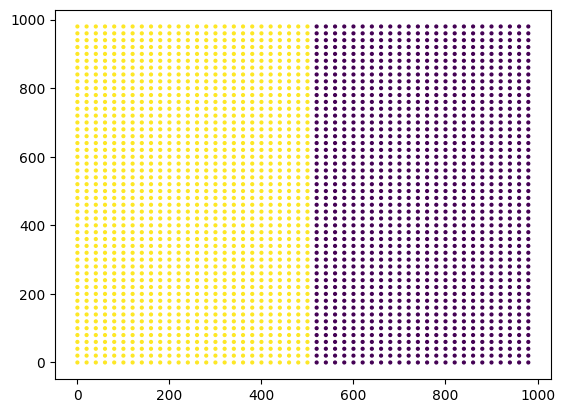

In [17]:
plt.scatter(bottom.vertices[:,0],
            bottom.vertices[:,1],
            c = bottom.vertices[:,2],
            s = 4)

# now you can play with this workflow below

In [ ]:
# quick check the structure grid
grid.visual_3D_from_formation_grid('top_to_bottom_formation',vertical_colorbar =False)

Widget(value="<iframe src='http://localhost:51524/index.html?ui=P_0x20e94a6a890_0&reconnect=auto' style='width…

In [3]:
grid.cmg_corner_point_generate(top_surface_name='top', bottom_surface_name='bottom' )

In [8]:
grid.write_cmg_corner_points_input_file('.','top_to_bottom_formation')

In [8]:
# load porosity and facies model whose size is 16x32x32 in z-, y-, and x-direction
Facies = np.load('facie_16x32x32.npy')
Porosity = np.load('porosity_16x32x32.npy')

In [9]:
# let's check what are existing formation_grids in "Stratigraphy_Grid"
grid.print_formation_grids()

formation_grids are ...: 
- top_to_bottom_formation


In [10]:
# add properties to the formation grid (resampling is required so it may takes around 15 sec each
grid._add_value_to_grid(formation_name='top_to_bottom_formation',value = Facies,value_name = 'Facies')
grid._add_value_to_grid(formation_name='top_to_bottom_formation',value = Porosity,value_name = 'Porosity')


Facies succesfully added to top_to_bottom_formation
formation_grids[formation_name].keys are ['xx', 'yy', 'zz', 'Facies']
Porosity succesfully added to top_to_bottom_formation
formation_grids[formation_name].keys are ['xx', 'yy', 'zz', 'Facies', 'Porosity']


In [11]:
# visualize Facies
grid.visual_3D_from_formation_grid('top_to_bottom_formation',value_name = 'Facies')

Widget(value="<iframe src='http://localhost:53448/index.html?ui=P_0x1fa90475d90_1&reconnect=auto' style='width…

## Don't forget to double check with the simple plt.imshow of top layer

Text(0, 0.5, 'Northing')

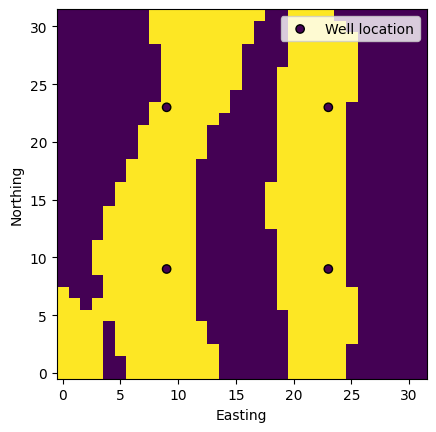

In [12]:
plt.imshow(Facies[0])
plt.gca().invert_yaxis()
plt.scatter([9,9,23,23],[9,23,9,23],c = [0, 0, 0, 0],edgecolors = 'k',marker = 'o', label = 'Well location')
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')